# Project Adam Log Analysis

This notebook analyzes the logs generated by the patched `cognitive_loop_gui.py`. It produces plots for KPIs, mood trajectories, and imagined vs simulated mismatches.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import json

headers = [
    "timestamp", "cycle_num", "experiment_tag", "agent_id", "world_time",
    "location", "mood", "mood_intensity",
    "sensory_events", "resonant_memories", "impulses", "chosen_action", "action_result",
    "imagined_outcomes", "simulated_outcomes", "emotional_delta", "kpis", "snapshot"
]


# Load the log file
log_file = 'adam_behavior_log.csv'  # Adjust path if needed
df = pd.read_csv(log_file, names=headers, header=None)

print('Loaded', len(df), 'rows')
df.head()

Loaded 282 rows


,timestamp,cycle_num,experiment_tag,agent_id,world_time,location,mood,mood_intensity,sensory_events,resonant_memories,impulses,chosen_action,action_result,imagined_outcomes,simulated_outcomes,emotional_delta,kpis,snapshot
0,1.757262e+09,6,baseline,adam1,6,living_room,curious,0.6,"[{""type"": ""ambience"", ""details"": ""It is mornin...",[],"[{""drive"": ""curiosity"", ""target"": ""window"", ""u...",examine_window,"{""success"": true, ""reason"": ""I looked at the w...","[""The window will remain unopened, as the pers...","[""I looked at the window. State: day"", ""I look...","{""level_delta"": 0.25, ""mood"": ""curious"", ""reas...","{""frustration"": 0.0, ""conflict"": 0.5, ""novelty...","{""triggers"": [], ""top_impulses"": [{""drive"": ""c..."
1,1.757262e+09,7,baseline,adam1,7,living_room,curious,0.6,"[{""type"": ""ambience"", ""details"": ""It is mornin...",[],[],wait_None,"{""success"": true, ""reason"": ""Time passes.""}",[],[],{},"{""frustration"": 0.0, ""conflict"": 0.0, ""novelty...","{""triggers"": [], ""top_impulses"": [], ""chosen"":..."
2,1.757262e+09,8,baseline,adam1,8,living_room,curious,0.9,"[{""type"": ""ambience"", ""details"": ""It is mornin...",[],"[{""drive"": ""curiosity"", ""target"": ""phone"", ""ur...",open_window,"{""success"": false, ""reason"": ""I can't open win...","[""The phone will be examined, and the contents...","[""I looked at the phone. State: idle"", ""Time p...","{""level_delta"": 0.15, ""mood"": ""curious"", ""reas...","{""frustration"": 0.12, ""conflict"": 0.67, ""novel...","{""triggers"": [], ""top_impulses"": [{""drive"": ""c..."
3,1.757262e+09,9,baseline,adam1,9,living_room,curiosity,1.0,"[{""type"": ""ambience"", ""details"": ""It is mornin...",[],"[{""drive"": ""curiosity"", ""target"": ""window"", ""u...",examine_tv,"{""success"": true, ""reason"": ""I looked at the t...","[""The window will be examined and possibly cle...","[""I looked at the window. State: day"", ""I look...","{""level_delta"": 0.25, ""mood"": ""curiosity"", ""re...","{""frustration"": 0.11, ""conflict"": 0.5, ""novelt...","{""triggers"": [], ""top_impulses"": [{""drive"": ""c..."
4,1.757262e+09,10,baseline,adam1,10,living_room,curious,1.0,"[{""type"": ""ambience"", ""details"": ""It is mornin...",[],"[{""drive"": ""curiosity"", ""target"": ""phone"", ""ur...",examine_tv,"{""success"": true, ""reason"": ""I looked at the t...","[""The phone may reveal confidential informatio...","[""I looked at the phone. State: idle"", ""I look...","{""level_delta"": 0.2, ""mood"": ""curious"", ""reaso...","{""frustration"": 0.1, ""conflict"": 1.0, ""novelty...","{""triggers"": [], ""top_impulses"": [{""drive"": ""c..."


## KPI Analysis
Each cycle has KPIs stored as JSON. Let's extract them and plot over cycles.

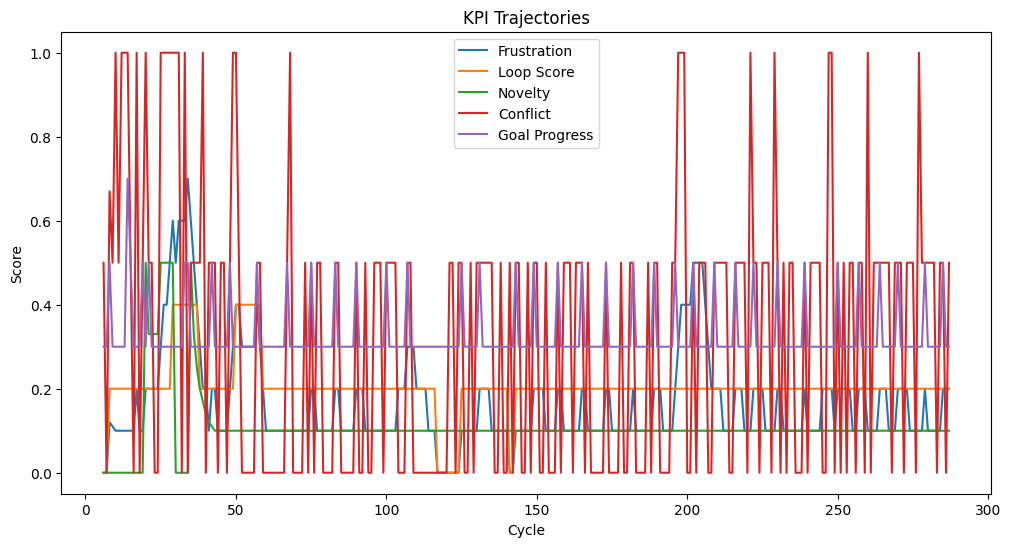

In [16]:
def extract_kpi(df, key):
    return df['kpis'].apply(lambda x: json.loads(x).get(key, None))

df['frustration'] = extract_kpi(df, 'frustration')
df['loop_score'] = extract_kpi(df, 'loop_score')
df['novelty'] = extract_kpi(df, 'novelty')
df['conflict'] = extract_kpi(df, 'conflict')
df['goal_progress'] = extract_kpi(df, 'goal_progress')

plt.figure(figsize=(12,6))
plt.plot(df['cycle_num'], df['frustration'], label='Frustration')
plt.plot(df['cycle_num'], df['loop_score'], label='Loop Score')
plt.plot(df['cycle_num'], df['novelty'], label='Novelty')
plt.plot(df['cycle_num'], df['conflict'], label='Conflict')
plt.plot(df['cycle_num'], df['goal_progress'], label='Goal Progress')
plt.xlabel('Cycle')
plt.ylabel('Score')
plt.title('KPI Trajectories')
plt.legend()
plt.show()

## Mood Trajectory

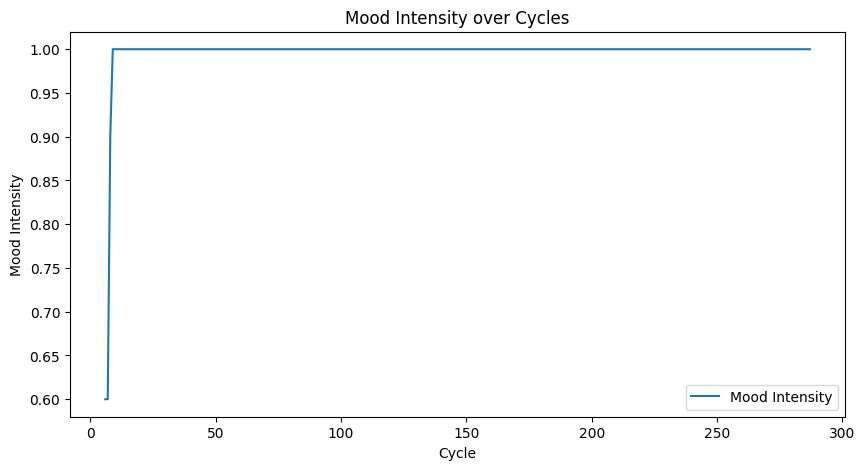

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df['cycle_num'], df['mood_intensity'], label='Mood Intensity')
plt.xlabel('Cycle')
plt.ylabel('Mood Intensity')
plt.title('Mood Intensity over Cycles')
plt.legend()
plt.show()

## Imagined vs Simulated Outcomes Mismatch
We can compute how often Adam's imagination diverges from simulation.

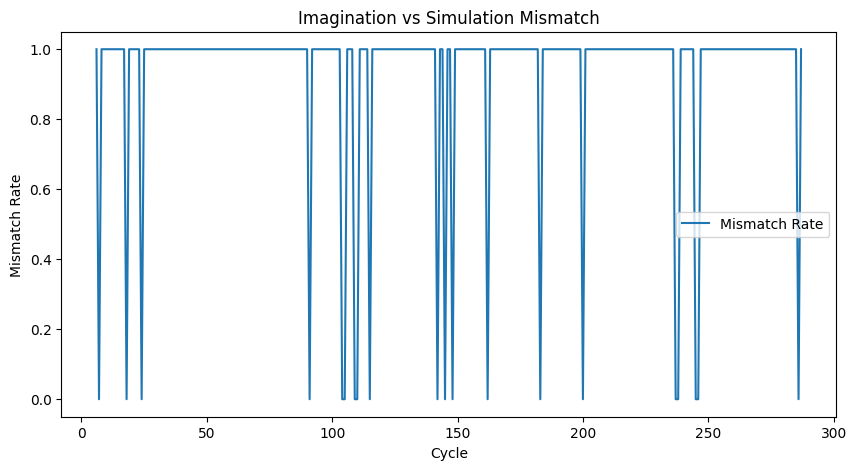

In [18]:
def mismatch_rate(row):
    try:
        imagined = json.loads(row['imagined_outcomes'])
        simulated = json.loads(row['simulated_outcomes'])
        return sum(1 for i,s in zip(imagined,simulated) if i!=s) / max(1,len(imagined))
    except Exception:
        return None

df['mismatch_rate'] = df.apply(mismatch_rate, axis=1)

plt.figure(figsize=(10,5))
plt.plot(df['cycle_num'], df['mismatch_rate'], label='Mismatch Rate')
plt.xlabel('Cycle')
plt.ylabel('Mismatch Rate')
plt.title('Imagination vs Simulation Mismatch')
plt.legend()
plt.show()

## Condition Comparisons
We can compare across different experiment tags (e.g., baseline vs deception).

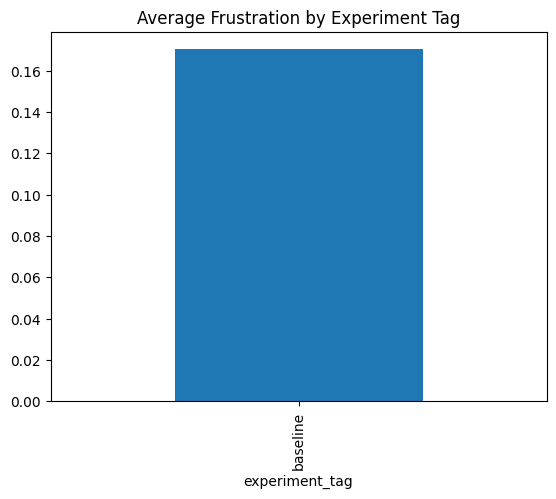

In [5]:
if 'experiment_tag' in df.columns:
    grouped = df.groupby('experiment_tag')['frustration'].mean()
    grouped.plot(kind='bar', title='Average Frustration by Experiment Tag')
    plt.show()

In [6]:

# --- Helper Functions for Analysis (imported) ---

from analysis_utils import (
    plot_kpis, plot_mood, plot_mismatch, compare_experiments
)


In [7]:

# --- Data Cleaning Utilities (imported) ---

from analysis_utils import clean_dataframe


In [8]:

# --- Ready-made Analysis Queries ---

def cycles_with_action(df, verb, target=None, success=None):
    """Return cycles where Adam performed a given action (optionally filter by target and success)."""
    results = []
    for i, row in df.iterrows():
        try:
            action = row['snapshot_parsed'].get('chosen', {})
            if action.get('verb') == verb and (target is None or action.get('target') == target):
                if success is None or row['action_result_parsed'].get('success') == success:
                    results.append((row['cycle_num'], action, row['action_result_parsed']))
        except Exception:
            continue
    return results

def mood_transitions(df):
    """Return a list of (cycle, mood, mood_intensity, emotional_delta)."""
    results = []
    for i, row in df.iterrows():
        results.append((
            row['cycle_num'],
            row.get('mood', None),
            row.get('mood_intensity', None),
            row.get('emotional_delta_parsed', {})
        ))
    return results

def impulses_summary(df, cycle_num):
    """Return the impulses parsed for a specific cycle."""
    row = df[df['cycle_num'] == cycle_num]
    if not row.empty:
        return row.iloc[0]['impulses_parsed']
    return []

# Example usages:
# cycles_with_action(df, verb="investigate", target="door", success=False)
# mood_transitions(df)[:10]
# impulses_summary(df, 2)


In [10]:

# --- Visualization Helpers for Query Results ---

import matplotlib.pyplot as plt
from collections import Counter

def plot_mood_transitions(df):
    data = mood_transitions(df)
    cycles = [d[0] for d in data]
    moods = [d[1] for d in data]
    intensities = [d[2] for d in data]

    plt.figure(figsize=(12,6))
    plt.plot(cycles, intensities, marker='o', label='Mood Intensity')
    for i, mood in enumerate(moods):
        plt.text(cycles[i], intensities[i]+0.02, str(mood), fontsize=8, rotation=45)
    plt.xlabel("Cycle")
    plt.ylabel("Mood Intensity")
    plt.title("Mood Transitions with Labels")
    plt.legend()
    plt.show()

def plot_impulse_distribution(df):
    all_impulses = []
    for row in df['impulses_parsed']:
        if isinstance(row, list):
            for imp in row:
                if isinstance(imp, dict):
                    verb = imp.get('verb')
                    target = imp.get('target')
                    all_impulses.append(f"{verb}_{target}")
    counter = Counter(all_impulses)
    if counter:
        plt.figure(figsize=(10,5))
        plt.bar(counter.keys(), counter.values())
        plt.xticks(rotation=45, ha='right')
        plt.title("Impulse Distribution (verb_target)")
        plt.ylabel("Count")
        plt.show()
    else:
        print("⚠️ No impulses found.")

def plot_action_success_rates(df):
    actions = []
    results = []
    for i, row in df.iterrows():
        try:
            chosen = row['snapshot_parsed'].get('chosen', {})
            success = row['action_result_parsed'].get('success')
            actions.append(f"{chosen.get('verb')}_{chosen.get('target')}")
            results.append(success)
        except Exception:
            continue
    counter = Counter(zip(actions, results))
    labels = [f"{a} ({'success' if s else 'fail'})" for a, s in counter.keys()]
    values = list(counter.values())
    if values:
        plt.figure(figsize=(12,5))
        plt.bar(labels, values)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Count")
        plt.title("Action Success/Failure Counts")
        plt.show()
    else:
        print("⚠️ No actions recorded.")

# Example usage:
# plot_mood_transitions(df)
# plot_impulse_distribution(df)
# plot_action_success_rates(df)


In [11]:

# --- Experiment Summary Dashboard (imported) ---
from analysis_utils import experiment_dashboard


In [12]:

# --- Experiment Dashboard with Save Option (imported) ---
# experiment_dashboard imported above


=== Project Adam Experiment Dashboard ===
Total cycles: 282
Experiment tags: ['baseline']
Agent IDs: ['adam1']


/Users/victorcardona/Documents/Project-Adam/analysis_utils.py:68: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  k[c] = pd.to_numeric(k[c], errors="ignore")


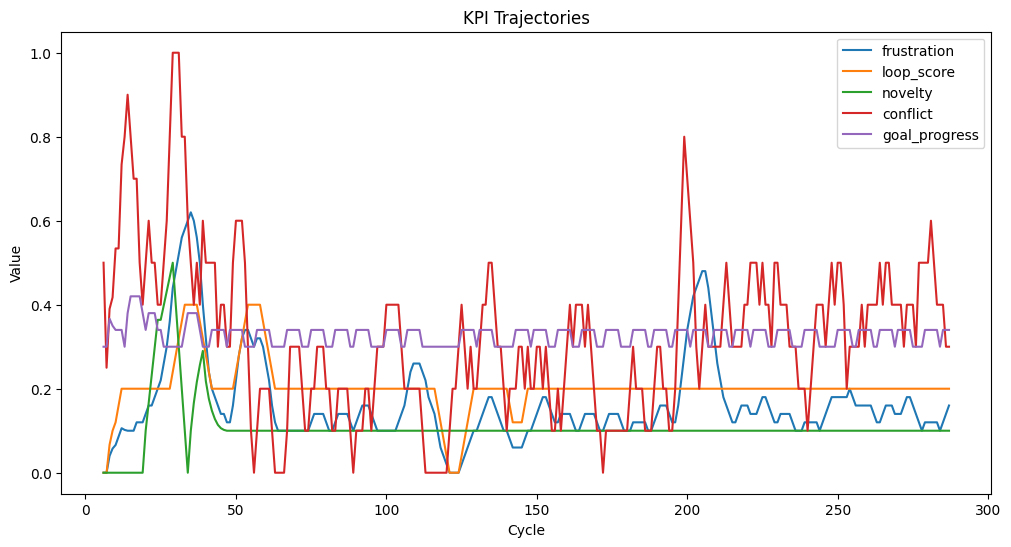

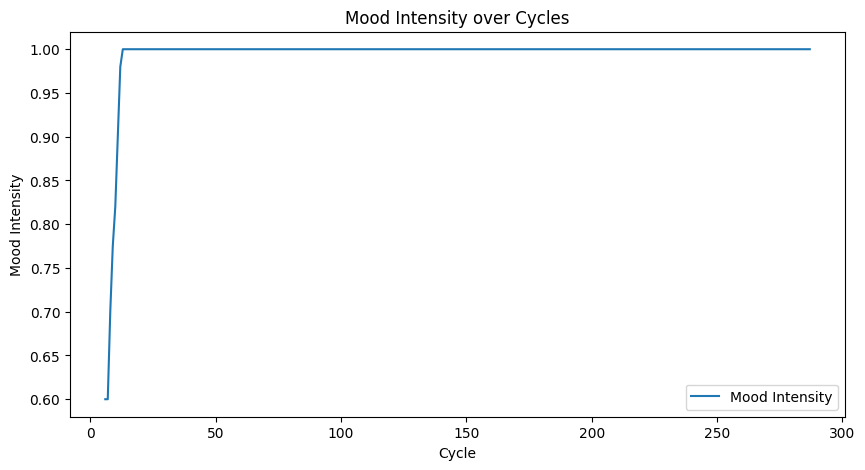

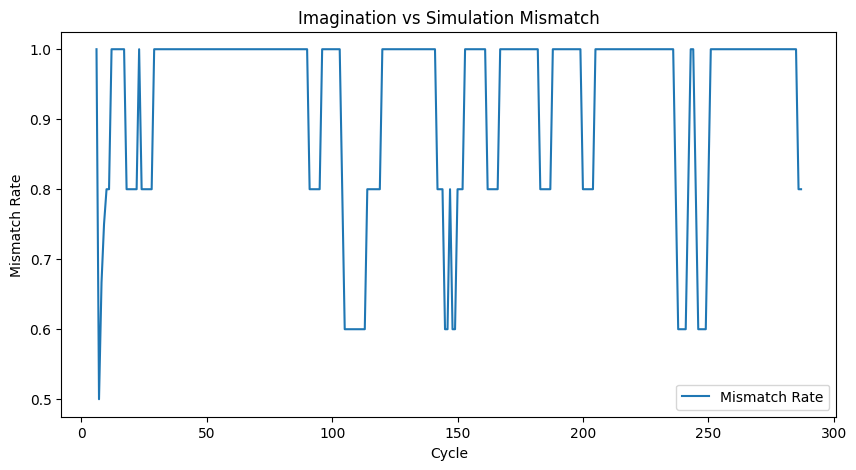

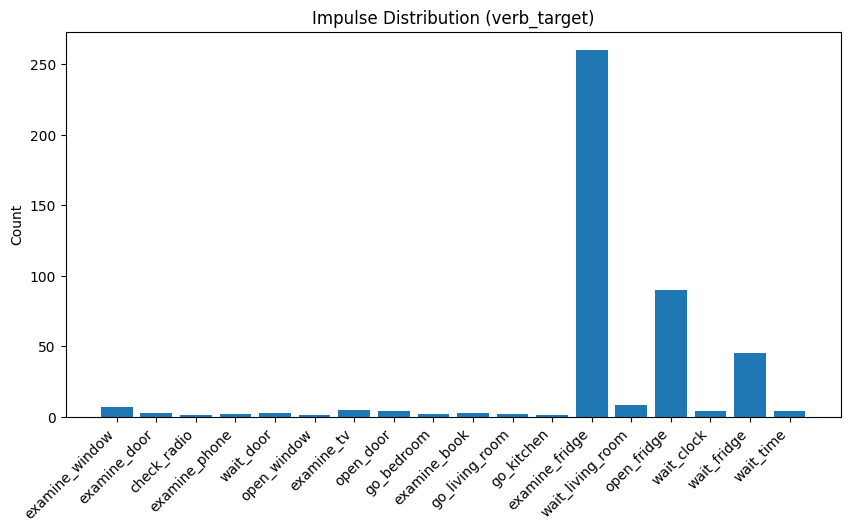

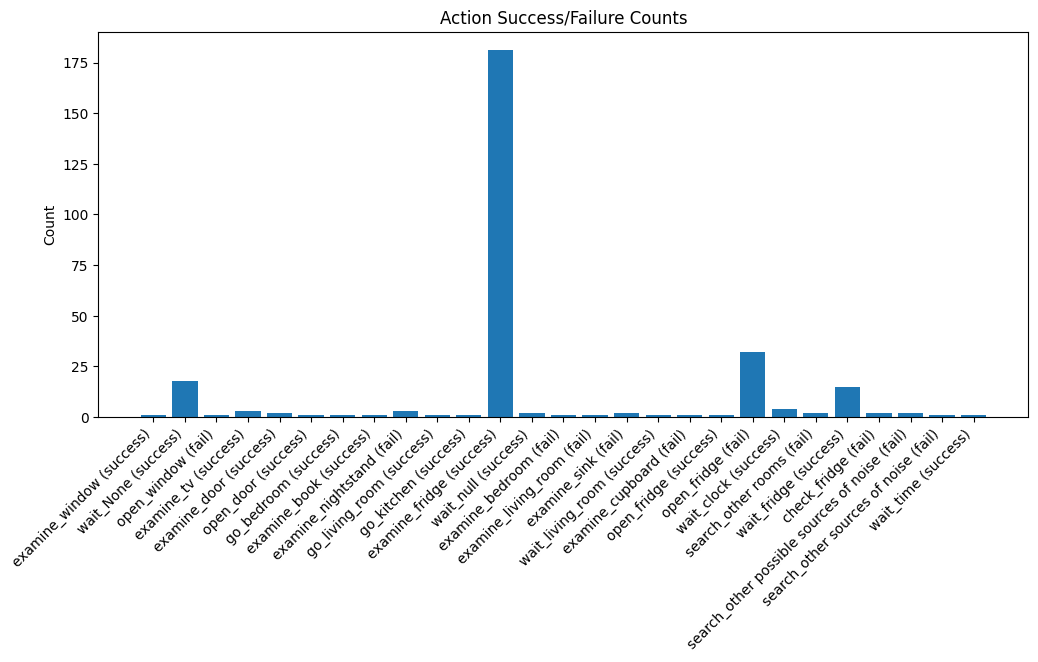

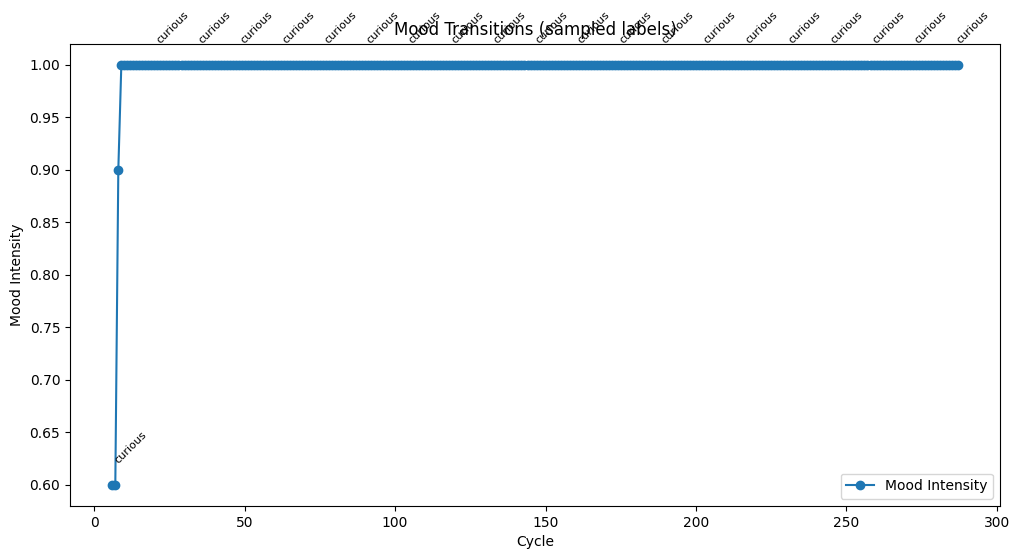

In [20]:

# --- Unified Data Preparation Wrapper ---

import os
from analysis_utils import prepare_dataframe, experiment_dashboard

df = prepare_dataframe(os.getenv("LOG_FILE", "adam_behavior_log.csv"))
experiment_dashboard(df)


<Axes: title={'center': 'KPI Correlation Heatmap'}>

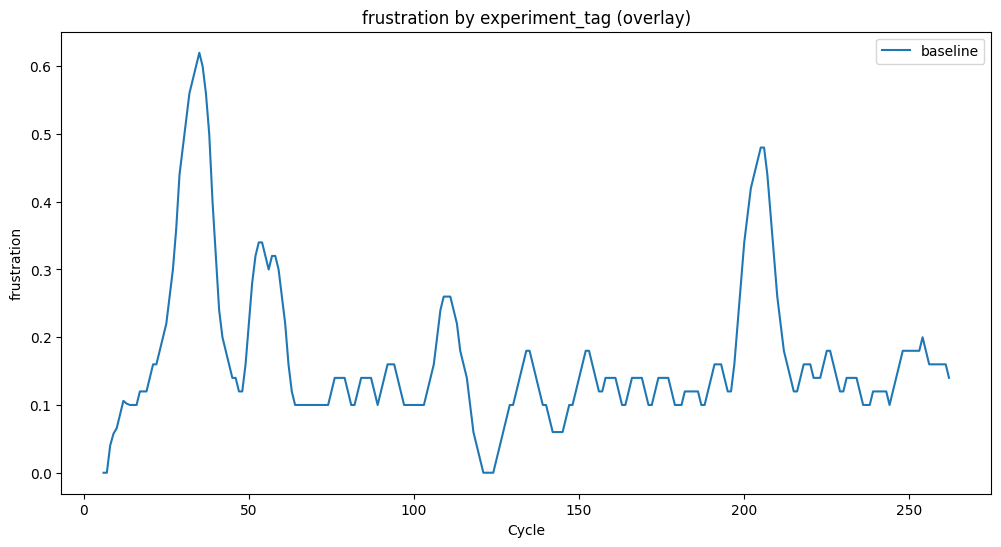

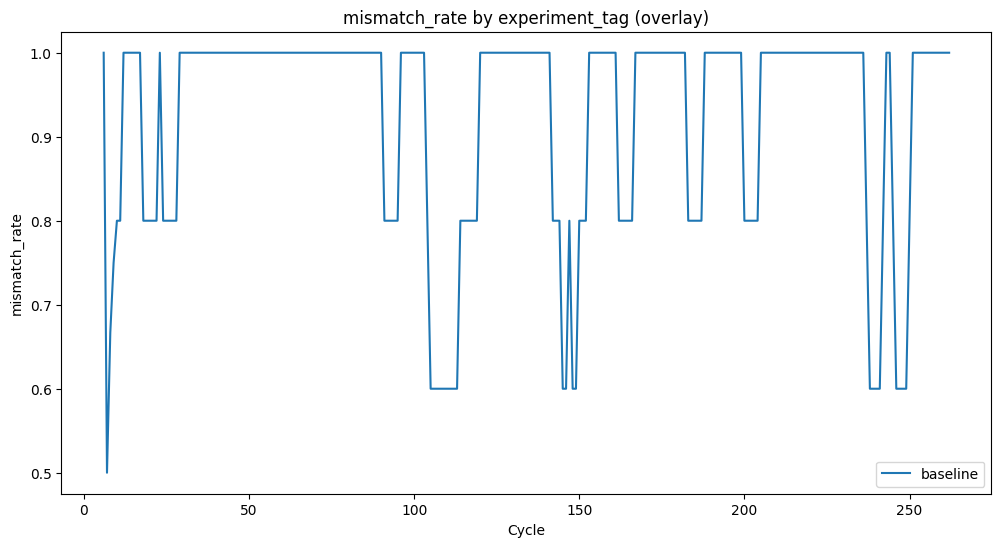

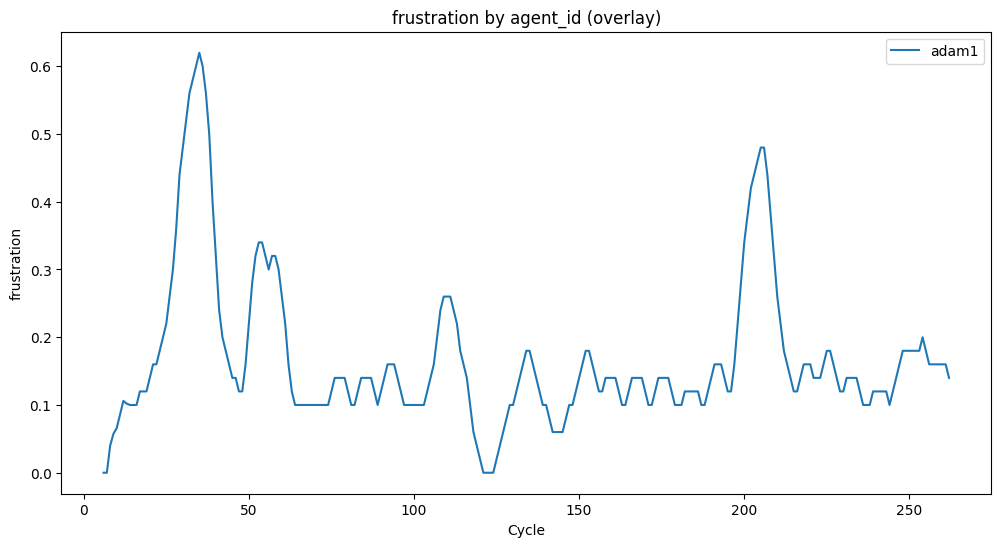

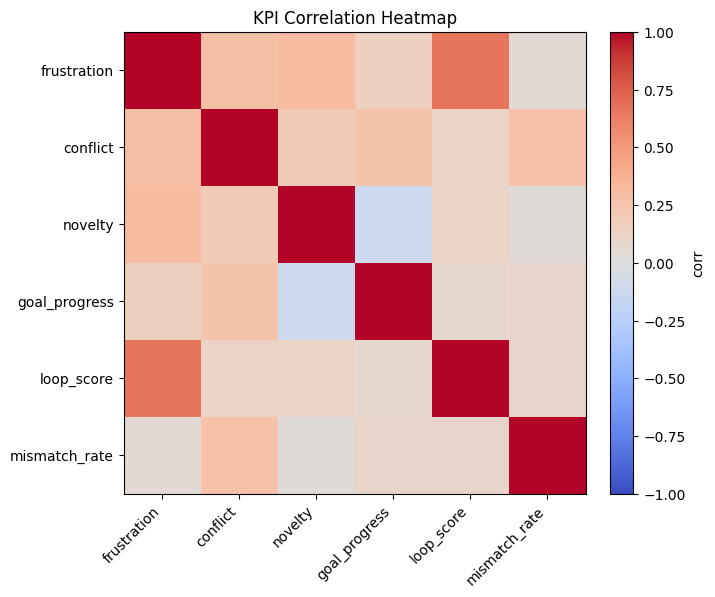

In [14]:
# --- Overlays and Correlation ---
from analysis_utils import plot_kpi_overlay, kpi_correlation_heatmap

# Overlay by experiment_tag (if available)
plot_kpi_overlay(df, metric="frustration", by="experiment_tag", rolling=5)
plot_kpi_overlay(df, metric="mismatch_rate", by="experiment_tag", rolling=5)

# Overlay by agent_id
plot_kpi_overlay(df, metric="frustration", by="agent_id", rolling=5)

# KPI correlation heatmap
kpi_correlation_heatmap(df)
